# Temperature change exposure using ERA weather and climatology, 2000-2015

- Project temperature changes between ERA interim and ERA climatology onto gridded population from NASA for 2000-2015
- Calculate global average as sum of exposure divided by total population

### Metric 1.1: Exposure to temperature change

The vulnerability to climate change is a function of the physical hazard (change in temperature, precipitation, humidity etc) and the number of (vulnerable) people exposed. A first order measure of exposure is defined here as:


$$
E(x,t) = \Delta T(x,t)P(x,t)
$$

and the global average is

$$
\bar{E} = \frac{\int \Delta T(x,t)P(x,t) dx}{\int P(x,t) dx}
$$

Where $\Delta T(x,t)$ is the change in the summer mean temperature (Northern Hemisphere JJA, Southern Hemisphere DJF) at location x at time t from the recent historical summer mean (1986-2005). $P(x,t)$ is the population at location x at time t in millions.

The relative population density was also proposed to calculate the global mean values of exposure;

$$
    E(x,t) = \frac{\Delta T(x,t)D(x,t)}{\bar D}
$$

Where $D(x,t) = \tfrac{P(x,t)}{A(x)}$ is the population density at x at time t, and $\bar D$ is the global mean population density. This will result in the same qualitative conclusions as equation 1, but the units have been converted from Kelvin millions of people to Kelvin for the exposure maps.

**NOTE: The aim of this final indicator is to have an axis in Kelvin, and this is probably the most important one. The reason for this is that it makes it easy to have plots of the raw temperature change and the exposure change side by side and demonstrate with comparable axes that there is an important difference between the change in temperature and the change in temperature experienced by people**


### Updates/Clarifications to Method

Aim is to measure 'temperature change experienced by people'. End goal is a value in Kelvin which is the equivalent of the global mean temperature change but weighted by population

We operate on gridded data.

First, just multiply the temperature change by the number of people at each point (x) for a given time (t):

$$
E(x,t) = \Delta T(x,t)P(x)
$$


We want to limit to the temperature change in the summer months for a given year, so first define all operations for a chosen year Y. The flobal $\Delta T(x,t)$ array is calculated by taking the mean temperature change for June, July, August for the northern hemisphere (latitude >= 0) and joining it with the array ofthe mean temperature change for December, January, February for the southern hemisphere (latitude < 0).

This gives a value in Kelvin x Npeople, which isn't hugely intuitive. When we take the global average with therefore divide by the total population for that year, $\sum P(x)$:

$$
\bar{E} = \frac{\sum \Delta T(x,t)P(x,t)}{\sum P(x)}
$$

This can be repeated for each year to get a time series. However, we'd also like to map the value for each year in a similarly intuitive way. We can do this using the mean population per grid point:

$$
\bar{P} = \sum P(x) / N
$$

And calculating the exposure at each point as the population divided by the mean population:

$$
E(x,t) = \Delta T(x,t)P(x) / \bar{P}
$$

The average of this value over the grid (with number of points N) is equal to the $\bar{E}$:


$$
Mean = \frac{\sum \Delta T(x,t)P(x,t) / \bar{P} }{N} \\
= \frac{\sum \Delta T(x,t)P(x,t) / (\sum P(x) / N) }{N} \\
= \frac{ \tfrac{N}{\sum P(x)} \sum \Delta T(x,t)P(x,t) }{N} \\
= \frac{ N   \sum \Delta T(x,t)P(x,t) }{N \sum P(x)} \\
= \frac{\sum \Delta T(x,t)P(x,t)}{\sum P(x)} = \bar{E} 
$$


#### Notes

Summer:

Northern Hemisphere JJA: June, July, August

Southern Hemisphere DJF: December, January, February



# TODO cleanup where the plots are made, maybe make more generic for easy update each year

In [1]:
%matplotlib inline

from pathlib import Path
from datetime import date

import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats
from tqdm import tnrange, tqdm_notebook


import weather_ecmwf
import population_tools

from config import (DATA_SRC, ERA_MONTHLY_FILE, 
                    CLIMATOLOGY_FILE_MONTHLY, POP_DATA_SRC)

# Load weather

In [2]:
era_weather = weather_ecmwf.weather_mfdataset(ERA_MONTHLY_FILE)
era_weather = era_weather.sel(time=slice('1980','2016'))

In [3]:
era_climatology = weather_ecmwf.climatology_dataset(CLIMATOLOGY_FILE_MONTHLY)

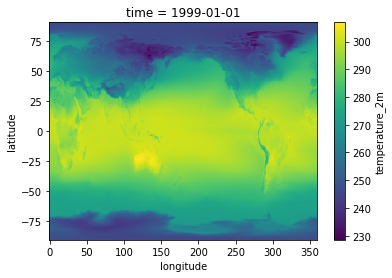

In [4]:
era_climatology.temperature_2m.sel(time='1999-01-01').plot()

## Get ∆T for each month of each year

- Group by time.year and apply subtraction for each month

In [5]:

def sub_months(era_t_yr):
    """Swap in the time axis so the datasets auto-align
    """
    tmp = era_climatology.temperature_2m.copy()
    tmp['time'] = era_t_yr.time
    return era_t_yr - tmp
    
delta_t = era_weather.temperature_2m.groupby('time.year').apply(sub_months)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


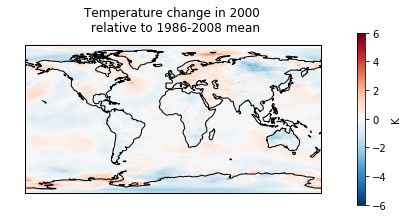

In [6]:
# Climate change in 2000
f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
delta_t.sel(time='2000').mean(dim='time').plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='K'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines()
ax.set_title('Temperature change in 2000 \n relative to 1986-2008 mean')
plt.tight_layout()

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1539: RuntimeWarning: invalid value encountered in greater
  to_mask = ((np.abs(dx_horizontal) > np.pi / 2) |


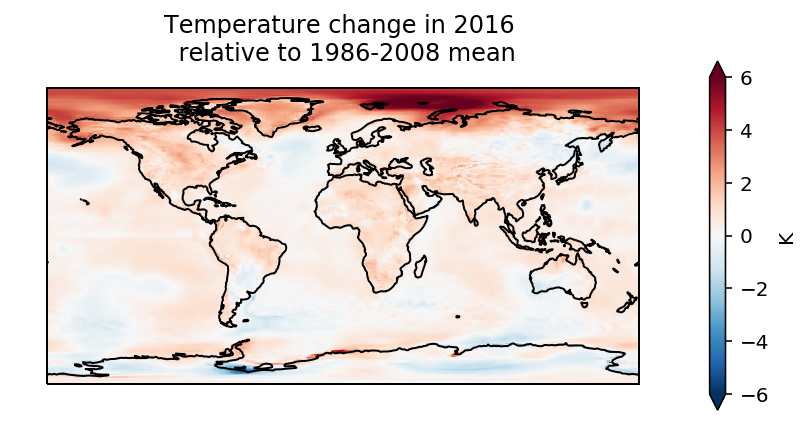

In [40]:
# Climate change in 2016
f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
delta_t.sel(time='2016').mean(dim='time').plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='K'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines()
ax.set_title('Temperature change in 2016 \n relative to 1986-2008 mean')
plt.tight_layout()


## Get the mean delta for each summer

In [6]:
def collect_summer_delta(delta_t):
    """Wrap in a function to clear temporary vars from memory"""
    # northern hemisphere
    lat_north = delta_t.latitude[delta_t.latitude >= 0]
    lat_south = delta_t.latitude[delta_t.latitude < 0]

    # Summer North
    summer_jja = delta_t['time.season'] == 'JJA'

    # Summer South
    summer_djf = delta_t['time.season'] == 'DJF'

    nh = delta_t.sel(time=summer_jja).groupby('time.year').mean(dim='time')
    sh = delta_t.sel(time=summer_djf).groupby('time.year').mean(dim='time')

    summer_anom = xr.concat([nh.sel(latitude=lat_north),  
                             sh.sel(latitude=lat_south)], dim='latitude')
    return summer_anom

summer_anom = collect_summer_delta(delta_t)

### Weight the gridded mean anomaly by the latitude and calculate the global mean

- It's important to weight the grid before calculating the mean to account for the change in area of grid units from the equator to the poles

In [7]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(summer_anom.latitude))
summer_anom_ts = (summer_anom.sel(year=slice('1980','2017')) * cos_lat).mean(dim=['latitude', 'longitude'])

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


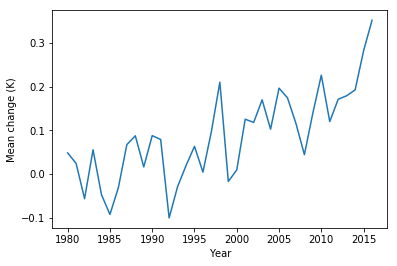

In [9]:
summer_anom_ts.plot()
plt.xlabel('Year')
plt.ylabel('Mean change (K)')

## Save the area weighted time series

In [10]:
summer_anom.name = 'summer_global'
summer_anom.to_netcdf(str(DATA_SRC /'lancet' / 'summer_global.nc'))

summer_anom_ts.name = 'summer_global'
summer_anom_ts.to_netcdf(str(DATA_SRC /'lancet' / 'summer_global_ts.nc'))

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


### Load the area weighted time series

In [13]:
summer_anom = xr.open_dataarray(str(DATA_SRC /'lancet' / 'summer_global.nc'))
summer_anom_ts = xr.open_dataarray(str(DATA_SRC /'lancet' / 'summer_global_ts.nc'))

## Project summer anomaly to total population

In [17]:
# def project_to_population(summer_anom):
    
#     with population_tools.PopulationProjector('population_count_2000-2020.nc') as pop:
#         pop_mean = pop.data.mean(dim=['latitude', 'longitude'])
#         pop_sum = pop.data.sum(dim=['latitude', 'longitude'])

#         def _gen():
#             for year in tnrange(2000,2017):
#                 yield pop.project(year, summer_anom.sel(year=year))
                
#         summer_exposures = xr.concat(_gen(), dim='year')   
#         summer_exposures_ts = (summer_exposures / pop_sum).sum(dim=['latitude', 'longitude']).compute()
#         summer_exposures = (summer_exposures / pop_mean).compute()
        
#         return summer_exposures, summer_exposures_ts
    
def project_to_population(anom_data, demographics=None, norm=False, start_year=2000, end_year=2017):
    
    with population_tools.PopulationProjector('population_count_2000-2020_highres.nc',
                                              'water_mask_eightres.tif') as pop:
        if demographics:
            pop_sel = (pop.data * demographics).compute()
        else:
            pop_sel = pop.data
        pop_sum = pop_sel.sum(dim=['latitude', 'longitude'], skipna=True)

        def do(year):
            proj = pop.project_param(anom_data.sel(year=year))
            proj = proj * pop_sel.sel(year=year)
            if norm:
                proj = proj / pop_sum.sel(year=year)
            return proj.compute()
        
        exposures = xr.concat((do(year) for year in range(start_year, end_year+1)), dim='year')   
        exposures_ts = exposures.sum(dim=['latitude', 'longitude'],
                                     skipna=True).compute()
        return exposures_ts

In [18]:
summer_exposures_ts = project_to_population(summer_anom, norm=True)

OSError: No such file or directory

## Save/load the exposure time series

In [29]:
summer_exposures_ts.name = 'summer_exposure'
summer_exposures_ts.to_netcdf(str(DATA_SRC /'lancet' / 'summer_exposure_ts.nc'))

In [12]:
summer_exposures_ts = xr.open_dataarray(str(DATA_SRC /'lancet' / 'summer_exposure_ts.nc'))

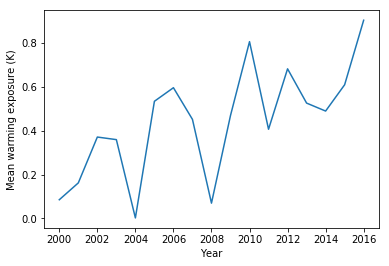

In [14]:
summer_exposures_ts.plot()
plt.xlabel('Year')
plt.ylabel('Mean warming exposure (K)')
# plt.savefig('mean_warming_experienced_2000-2015.png', dpi=300)
# plt.savefig('mean_warming_experienced_2000-2015.pdf', dpi=300)

## Plot the time series

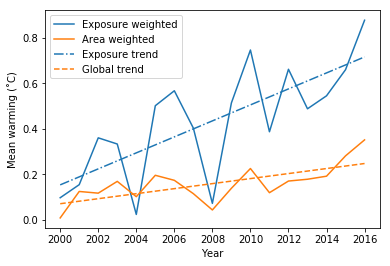

In [15]:
summer_exposures_ts.plot(color='C0',label='Exposure weighted')
summer_anom_ts.plot(color='C1',label='Area weighted')
# mean_exposures_ts.plot(color='C9', label='Experienced, Year 2000 baseline')

summer_anom_reg = stats.linregress(summer_anom_ts.year.values, summer_anom_ts.values)
summer_anom_reg = (summer_anom_reg.slope * summer_anom_ts.year) + summer_anom_reg.intercept

summer_exposures_reg = stats.linregress(summer_exposures_ts.year.values, summer_exposures_ts.values)
summer_exposures_reg = (summer_exposures_reg.slope * summer_exposures_ts.year) + summer_exposures_reg.intercept

summer_exposures_reg.plot.line('-.', color='C0', label='Exposure trend')
summer_anom_reg.plot.line('--', color='C1', label='Global trend')

plt.xlabel('Year')
plt.ylabel('Mean warming (˚C)')
plt.legend()
plt.savefig('mean_warming_experienced_2000-2016.png', dpi=300)
plt.savefig('mean_warming_experienced_2000-2016.pdf')

In [35]:
# Save to excel
output = summer_anom_ts.to_dataframe().join(summer_exposures_ts.to_dataframe())
output.columns = ['Area weighted change K ', 'Exposure weighted change K']

output.to_excel(str(DATA_SRC / 'lancet' / 'temperature_change.xlsx'), sheet_name='temperature_change')

## Map plots

- Plot the indicator at start, end, and difference between the two


In [1]:
year_anom_delta = summer_anom.mean(dim='year')

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.PlateCarree())
year_anom_delta.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='K'))
ax.coastlines()
ax.set_title('Mean yearly change in 2000-2016')
plt.tight_layout()
f.savefig('temperature_change_delta_2000-2016.png')